# 1. Disciplina de Introdução a Banco de Dados - 2025/02
### Trabalho Prático 2: Análise de Dados de um Dataset de Alunos de Iniciação Científica

# 2. Membros (nome e número de matrícula)

- Arthur Augusto Paiva Lemos - 2023427414
- Filipe Henrique Nunes -  2023038329
- Rafaela Kesia Ferreira da Silva - 2025019879
- Raissa Gonçalves Diniz - 2022055823

# 3. Descrição dos dados (qual a URL? qual o domínio? como os dados foram processados?)

## 3.1 Fonte de Dados Principal

- **URL:** https://dados.gov.br/dados/conjuntos-dados/alunos-de-iniciacao-cientifica
- **Domínio:** Educação Superior - Iniciação Científica da UFTM
- **Dataset:** "Informações Acadêmicas - Alunos De Iniciação Científica - 2025" (catalogado em 28/03/2025)
- **Descrição:** Contém informações sobre estudantes de iniciação científica da Universidade Federal do Triângulo Mineiro (UFTM), incluindo dados sobre projetos, orientadores, cursos, períodos de vigência e fomento.

## 3.2 Enriquecimento dos Dados

Para atender aos requisitos do trabalho (mínimo de 2 atributos por entidade além do identificador), realizamos um **cruzamento de dados** com três datasets adicionais da UFTM, todos públicos e atualizados em 2025:

**Datasets complementares:**
1. **Docentes Ativos:** https://dados.gov.br/dados/conjuntos-dados/docentes-ativos
   - Atributos adicionados aos orientadores: titulação, vínculo, classe funcional, regime de trabalho, lotação e data de ingresso

2. **Cursos de Graduação:** https://dados.gov.br/dados/conjuntos-dados/informacoes-academicas---cursos-de-graduacao
   - Atributos adicionados aos cursos: município, grau, modalidade, turno, ato autorizativo e data de funcionamento

3. **Alunado de Graduação:** https://dados.gov.br/dados/conjuntos-dados/alunado-dos-cursos-de-graduacao
   - Atributos adicionados aos alunos: campus, ano de ingresso, forma de ingresso e situação do vínculo

## 3.3 Processamento dos Dados

1. **Carregamento:** Todos os arquivos CSV foram importados para um banco de dados SQLite
2. **Cruzamento:** Realizamos LEFT JOIN entre as tabelas usando:
   - Nome do aluno (para dados de graduação)
   - Nome do curso (para dados do curso)
   - Nome do orientador (para dados dos docentes)
3. **Limpeza:** Removemos registros com cruzamento incompleto (onde algum dos três joins não obteve correspondência)
4. **Transformação:** Gerado atributo sintético "Tipo" para Órgão de Fomento (classificação em Federal/Estadual/Institucional)
5. **Normalização:** Criação do modelo relacional com 5 entidades: Aluno, Curso, Orientador, Projeto e Órgão_Fomento

**Resultado:** Dataset final com 100% de matches nas três dimensões (aluno, curso e orientador), garantindo integridade referencial completa.

In [25]:
import csv
import pandas as pd
import sqlite3
import re
from unidecode import unidecode

In [26]:
def fetch(query, conn, formatted=True):
    """Executa query e retorna DataFrame ou lista de tuplas"""
    cur = conn.cursor()
    cur.execute(query)
    rs = cur.fetchall()
    columns = [desc[0] for desc in cur.description]
    return pd.DataFrame(rs, columns=columns) if formatted else rs

def show_tables(conn):
    """Lista todas as tabelas do banco"""
    return [x[0] for x in fetch('SELECT tbl_name FROM sqlite_master WHERE type="table"', conn, False)]

def shape(table, conn):
    """Retorna dimensões da tabela (linhas, colunas)"""
    nrows = fetch(f'SELECT COUNT(*) FROM {table}', conn, False)[0][0]
    ncols = fetch(f'SELECT COUNT(*) FROM pragma_table_info("{table}")', conn, False)[0][0]
    return (nrows, ncols)

def desc(table, conn):
    """Lista nomes das colunas"""
    cur = conn.cursor()
    cur.execute(f'PRAGMA table_info("{table}")')
    columns = [row[1] for row in cur.fetchall()]
    return columns

def info(table, conn):
    """Informações detalhadas sobre a tabela (análogo ao pandas.info())"""
    df1 = fetch(f'PRAGMA table_info("{table}")', conn)
    columns = desc(table, conn)
    
    # total de entradas por coluna
    counts = ', '.join([f'COUNT(*) AS "{column}"' for column in columns])
    df2 = fetch(f'SELECT {counts} FROM "{table}"', conn).transpose()
    df2.columns = ['count']
    
    # entradas não-nulas por coluna
    counts = ', '.join([f'COUNT("{column}") AS "{column}"' for column in columns])
    df3 = fetch(f'SELECT {counts} FROM "{table}"', conn).transpose()
    df3.columns = ['notnull count']

    # entradas únicas não-nulas por coluna
    counts = ', '.join([f'COUNT(DISTINCT "{column}") AS "{column}"' for column in columns])
    df4 = fetch(f'SELECT {counts} FROM "{table}"', conn).transpose()
    df4.columns = ['unique count']
    
    return df1.merge(df2, left_on='name', right_index=True) \
            .merge(df3, left_on='name', right_index=True) \
            .merge(df4, left_on='name', right_index=True)

In [27]:
# Dicionário com todos os arquivos e seus encodings
arquivos = {
    'alunos_ic': {
        'arquivo': './data/alunos_ic.csv',
        'encoding': 'latin-1',
        'delimiter': ';'
    },
    'lista_alunos_graduacao': {
        'arquivo': './data/ListaAlunadoGraduacao.csv',
        'encoding': 'utf-8',
        'delimiter': ';'
    },
    'lista_cursos_graduacao': {
        'arquivo': './data/ListaCursosGraduacao.csv',
        'encoding': 'utf-8',
        'delimiter': ';'
    },
    'lista_docentes': {
        'arquivo': './data/ListaDocentes.csv',
        'encoding': 'utf-8',
        'delimiter': ';'
    }
}

# Conectar ao banco SQLite
conn = sqlite3.connect('ic-uftm.db')
cur = conn.cursor()

# Configurar PRAGMA para ingestão mais rápida
cur.execute('PRAGMA synchronous = OFF')
cur.execute('PRAGMA journal_mode = MEMORY')

BATCH_SIZE = 1000

# Carregar cada arquivo
for tabela, config in arquivos.items():
    print(f"\nCarregando {tabela}...")
    
    cur.execute('BEGIN TRANSACTION')
    
    # Dropar tabela se existir
    cur.execute(f'DROP TABLE IF EXISTS {tabela}')
    
    with open(config['arquivo'], 'r', encoding=config['encoding']) as f:
        reader = csv.reader(f, delimiter=config['delimiter'], quotechar='"')
        header = next(reader)
        num_columns = len(header)
        
        print(f"  Colunas esperadas: {num_columns}")
        print(f"  Header: {header[:3]}...")  # Mostrar primeiras 3 colunas
        
        # Criar tabela
        columns = [f'"{col.strip()}"' for col in header]
        create = f'CREATE TABLE {tabela} ({", ".join(columns)})'
        cur.execute(create)
        
        # Preparar INSERT
        placeholders = ', '.join(['?'] * num_columns)
        insert = f'INSERT INTO {tabela} VALUES ({placeholders})'
        
        # Processar em batches
        batch = []
        skipped = 0
        for i, row in enumerate(reader, start=2):  # start=2 porque header é linha 1
            # Verificar se a linha tem o número correto de colunas
            if len(row) != num_columns:
                skipped += 1
                print(f"  AVISO: Linha {i} tem {len(row)} colunas (esperado {num_columns}). Pulando...")
                continue
            
            batch.append(row)
            if len(batch) == BATCH_SIZE:
                cur.executemany(insert, batch)
                batch = []
        
        if batch:
            cur.executemany(insert, batch)
        
        if skipped > 0:
            print(f"{skipped} linhas puladas por incompatibilidade")
    
    # Converter valores vazios em NULL
    update = f'UPDATE {tabela} SET ' + ','.join([f'{col} = NULLIF({col}, "")' for col in columns])
    cur.execute(update)
    
    conn.commit()
    print(f"✓ {tabela} carregada com sucesso!")

# Restaurar PRAGMA
cur.execute('PRAGMA synchronous = FULL')
cur.execute('PRAGMA journal_mode = DELETE')

print("\n=== Todos os dados carregados! ===")


Carregando alunos_ic...
  Colunas esperadas: 9
  Header: ['Nome do Aluno', 'Código do Projeto (nº Matrícula)', 'Curso do Aluno']...
✓ alunos_ic carregada com sucesso!

Carregando lista_alunos_graduacao...
  Colunas esperadas: 6
  Header: ['nome', 'curso', 'campus']...
✓ lista_alunos_graduacao carregada com sucesso!

Carregando lista_cursos_graduacao...
  Colunas esperadas: 8
  Header: ['codigo_mec', 'curso', 'municipio']...
✓ lista_cursos_graduacao carregada com sucesso!

Carregando lista_docentes...
  Colunas esperadas: 8
  Header: ['siape', 'nome', 'titulacao']...
✓ lista_docentes carregada com sucesso!

=== Todos os dados carregados! ===


In [28]:
print("Tabelas no banco:")
show_tables(conn)

Tabelas no banco:


['Curso',
 'sqlite_sequence',
 'Aluno',
 'Orientador',
 'Projeto',
 'Orgao_Fomento',
 'Participa',
 'alunos_ic',
 'lista_alunos_graduacao',
 'lista_cursos_graduacao',
 'lista_docentes']

In [29]:
# ========================================
# CRUZAMENTO DE DADOS
# ========================================

# Query para cruzar todas as informações
query_cruzamento = '''
CREATE TABLE alunos_ic_enriquecido AS
SELECT 
    -- Dados originais de IC
    ic."Nome do Aluno",
    ic."Código do Projeto (nº Matrícula)",
    ic."Curso do Aluno",
    ic."Data de Início do Projeto",
    ic."Data de Fim do Projeto",
    ic."Fomento do Aluno",
    ic."Título do Projeto",
    ic."Orientador",
    ic."Edital",
    
    -- Dados do aluno (de lista_alunos_graduacao)
    alunos.campus AS aluno_campus,
    alunos.ano_ingresso AS aluno_ano_ingresso,
    alunos.forma_ingresso AS aluno_forma_ingresso,
    alunos.situacao_vinculo AS aluno_situacao_vinculo,
    
    -- Dados do curso (de lista_cursos_graduacao)
    cursos.municipio AS curso_municipio,
    cursos.grau AS curso_grau,
    cursos.modalidade AS curso_modalidade,
    cursos.turno AS curso_turno,
    cursos.ultimo_ato_autorizativo AS curso_ultimo_ato,
    cursos.data_funcionamento AS curso_data_funcionamento,
    
    -- Dados do orientador (de lista_docentes)
    docentes.titulacao AS orientador_titulacao,
    docentes.vinculo AS orientador_vinculo,
    docentes.classe_funcional AS orientador_classe,
    docentes.regime_trabalho AS orientador_regime,
    docentes.lotacao AS orientador_lotacao,
    docentes.data_ingresso AS orientador_data_ingresso

FROM alunos_ic ic

-- JOIN com alunos (por nome)
LEFT JOIN lista_alunos_graduacao alunos 
    ON LOWER(TRIM(ic."Nome do Aluno")) = LOWER(TRIM(alunos.nome))

-- JOIN com cursos (por nome do curso)
LEFT JOIN lista_cursos_graduacao cursos 
    ON LOWER(TRIM(ic."Curso do Aluno")) = LOWER(TRIM(cursos.curso))

-- JOIN com docentes (por nome do orientador)
LEFT JOIN lista_docentes docentes 
    ON LOWER(TRIM(ic."Orientador")) = LOWER(TRIM(docentes.nome))
'''

cur.execute(query_cruzamento)
conn.commit()

print("✓ Tabela enriquecida criada!")

✓ Tabela enriquecida criada!


In [30]:
# Verificar resultados
print("\nEstatísticas do cruzamento:")
stats = fetch('''
SELECT 
    COUNT(*) as total_registros,
    COUNT(aluno_campus) as alunos_encontrados,
    COUNT(curso_municipio) as cursos_encontrados,
    COUNT(orientador_titulacao) as orientadores_encontrados
FROM alunos_ic_enriquecido
''', conn)
print(stats)

# Exportar para CSV
print("\nExportando para CSV...")
df_enriquecido = fetch('SELECT * FROM alunos_ic_enriquecido', conn)
df_enriquecido.to_csv('alunos_ic_enriquecido.csv', index=False, encoding='utf-8', sep=';')
print("CSV 'alunos_ic_enriquecido.csv' gerado com sucesso!")

print("\nPrimeiras 5 linhas do dataset enriquecido:")
fetch('SELECT * FROM alunos_ic_enriquecido LIMIT 5', conn)


Estatísticas do cruzamento:
   total_registros  alunos_encontrados  cursos_encontrados  \
0              588                 406                 579   

   orientadores_encontrados  
0                       548  

Exportando para CSV...
CSV 'alunos_ic_enriquecido.csv' gerado com sucesso!

Primeiras 5 linhas do dataset enriquecido:


,Nome do Aluno,Código do Projeto (nº Matrícula),Curso do Aluno,Data de Início do Projeto,Data de Fim do Projeto,Fomento do Aluno,Título do Projeto,Orientador,Edital,aluno_campus,...,curso_modalidade,curso_turno,curso_ultimo_ato,curso_data_funcionamento,orientador_titulacao,orientador_vinculo,orientador_classe,orientador_regime,orientador_lotacao,orientador_data_ingresso
0,Adelson Antonio Januario Junior,5082,EDUCAÇÃO FÍSICA (Bacharelado),01/10/2023,30/09/2024,PIBIC/FAPEMIG,EFEITO DO TREINAMENTO RESISTIDO NA COMPOSIÇÃO ...,CLAUDIO DE OLIVEIRA ASSUMPCAO,Edital 22/2023 - Iniciação Científica e Tecnol...,Uberaba,...,Presencial,integral,PORTARIA DE RENOVAÇÃO DE RECONHECIMENTO Nº. 11...,03/03/2009,ENSINO SUPERIOR,Servidor Ativo,E,DEDICACAO EXCLUSIVA,INSTITUTO DE CIÊNCIAS DA SAÚDE,13/10/2021
1,Adônis Rossetti,4178,MEDICINA (Bacharelado),21/03/2023,20/03/2024,Sem bolsa,O impacto das mídias sociais na visão corporal...,VITOR HUGO DE OLIVEIRA,Edital 01/2023 - Iniciação Científica sem bols...,Uberaba,...,Presencial,integral,PORTARIA DE RENOVAÇÃO DE RECONHECIMENTO Nº. 53...,24/03/1954,DOUTORADO,Servidor Ativo,E,DEDICACAO EXCLUSIVA,INSTITUTO DE CIÊNCIAS DA SAÚDE,29/10/2020
2,Agatha Ferreira Souza,8155,BIOMEDICINA (Bacharelado),01/10/2024,30/09/2025,PIBIC/FAPEMIG,Análise pangenômica e de plasticidade do gêner...,Wellington Francisco Rodrigues,Edital 20/2024 - Iniciação Científica e Tecnol...,Uberaba,...,Presencial,integral,PORTARIA DE RENOVAÇÃO DE RECONHECIMENTO Nº. 11...,02/08/1999,None,None,None,None,None,None
3,Agnaldo José Braga Junior,4831,ENGENHARIA AMBIENTAL (Bacharelado),01/09/2023,31/08/2024,PIBIC-Af/CNPq,Efeitos da sujidade no desempenho de placas fo...,Julio Cesar De Souza Inacio Goncalves,Edital 14/2023 - Iniciação Científica e Tecnol...,Uberaba,...,Presencial,integral,PORTARIA DE RENOVAÇÃO DE RECONHECIMENTO Nº. 11...,22/02/2010,MESTRADO,Servidor Ativo,E,DEDICACAO EXCLUSIVA,PRÓ-REITORIA DE PESQUISA E PÓS-GRADUAÇÃO,03/03/2011
4,Alan de Castro Barbosa,5137,MEDICINA (Bacharelado),01/10/2023,30/09/2024,PIBIC/FAPEMIG,Perfil de citocinas associadas a polimorfismos...,Rodrigo Anselmo Cazzaniga,Edital 22/2023 - Iniciação Científica e Tecnol...,Uberaba,...,Presencial,integral,PORTARIA DE RENOVAÇÃO DE RECONHECIMENTO Nº. 53...,24/03/1954,None,None,None,None,None,None


In [31]:
# ========================================
# LIMPEZA: Remover linhas com cruzamentos incompletos
# ========================================

print("\n=== Limpando dados incompletos ===\n")

# Verificar quantas linhas temos antes da limpeza
total_antes = fetch('SELECT COUNT(*) FROM alunos_ic_enriquecido', conn, False)[0][0]
print(f"Total de registros ANTES da limpeza: {total_antes}")

# Criar tabela limpa (TODAS as três informações devem estar presentes)
cur.execute('DROP TABLE IF EXISTS alunos_ic_enriquecido_limpo')

cur.execute('''
CREATE TABLE alunos_ic_enriquecido_limpo AS
SELECT * FROM alunos_ic_enriquecido
WHERE 
    aluno_campus IS NOT NULL AND 
    curso_municipio IS NOT NULL AND 
    orientador_titulacao IS NOT NULL
''')

conn.commit()

# Verificar quantas linhas temos depois da limpeza
total_depois = fetch('SELECT COUNT(*) FROM alunos_ic_enriquecido_limpo', conn, False)[0][0]
removidos = total_antes - total_depois

print(f"Total de registros DEPOIS da limpeza: {total_depois}")
print(f"Registros removidos (cruzamento incompleto): {removidos}")

# Mostrar estatísticas de quantos matches foram perdidos
print("\nDetalhes dos registros REMOVIDOS:")
stats_removidos = fetch('''
SELECT 
    COUNT(*) as total_removidos,
    COUNT(aluno_campus) as tinham_aluno,
    COUNT(curso_municipio) as tinham_curso,
    COUNT(orientador_titulacao) as tinham_orientador
FROM alunos_ic_enriquecido
WHERE NOT (
    aluno_campus IS NOT NULL AND 
    curso_municipio IS NOT NULL AND 
    orientador_titulacao IS NOT NULL
)
''', conn)
print(stats_removidos)

# Estatísticas da tabela limpa
print("\nEstatísticas da tabela LIMPA (100% de matches):")
stats_limpo = fetch('''
SELECT 
    COUNT(*) as total_registros,
    COUNT(aluno_campus) as alunos_encontrados,
    COUNT(curso_municipio) as cursos_encontrados,
    COUNT(orientador_titulacao) as orientadores_encontrados
FROM alunos_ic_enriquecido_limpo
''', conn)
print(stats_limpo)

# Exportar versão limpa
print("\nExportando versão LIMPA para CSV...")
df_limpo = fetch('SELECT * FROM alunos_ic_enriquecido_limpo', conn)
df_limpo.to_csv('alunos_ic_enriquecido.csv', index=False, encoding='utf-8-sig', sep=';')
print("✓ CSV 'alunos_ic_enriquecido.csv' gerado!")

print("\nPrimeiras 5 linhas do dataset LIMPO:")
fetch('SELECT * FROM alunos_ic_enriquecido_limpo LIMIT 5', conn)


=== Limpando dados incompletos ===

Total de registros ANTES da limpeza: 588
Total de registros DEPOIS da limpeza: 372
Registros removidos (cruzamento incompleto): 216

Detalhes dos registros REMOVIDOS:
   total_removidos  tinham_aluno  tinham_curso  tinham_orientador
0              216            34           207                176

Estatísticas da tabela LIMPA (100% de matches):
   total_registros  alunos_encontrados  cursos_encontrados  \
0              372                 372                 372   

   orientadores_encontrados  
0                       372  

Exportando versão LIMPA para CSV...
✓ CSV 'alunos_ic_enriquecido.csv' gerado!

Primeiras 5 linhas do dataset LIMPO:


,Nome do Aluno,Código do Projeto (nº Matrícula),Curso do Aluno,Data de Início do Projeto,Data de Fim do Projeto,Fomento do Aluno,Título do Projeto,Orientador,Edital,aluno_campus,...,curso_modalidade,curso_turno,curso_ultimo_ato,curso_data_funcionamento,orientador_titulacao,orientador_vinculo,orientador_classe,orientador_regime,orientador_lotacao,orientador_data_ingresso
0,Adelson Antonio Januario Junior,5082,EDUCAÇÃO FÍSICA (Bacharelado),01/10/2023,30/09/2024,PIBIC/FAPEMIG,EFEITO DO TREINAMENTO RESISTIDO NA COMPOSIÇÃO ...,CLAUDIO DE OLIVEIRA ASSUMPCAO,Edital 22/2023 - Iniciação Científica e Tecnol...,Uberaba,...,Presencial,integral,PORTARIA DE RENOVAÇÃO DE RECONHECIMENTO Nº. 11...,03/03/2009,ENSINO SUPERIOR,Servidor Ativo,E,DEDICACAO EXCLUSIVA,INSTITUTO DE CIÊNCIAS DA SAÚDE,13/10/2021
1,Adônis Rossetti,4178,MEDICINA (Bacharelado),21/03/2023,20/03/2024,Sem bolsa,O impacto das mídias sociais na visão corporal...,VITOR HUGO DE OLIVEIRA,Edital 01/2023 - Iniciação Científica sem bols...,Uberaba,...,Presencial,integral,PORTARIA DE RENOVAÇÃO DE RECONHECIMENTO Nº. 53...,24/03/1954,DOUTORADO,Servidor Ativo,E,DEDICACAO EXCLUSIVA,INSTITUTO DE CIÊNCIAS DA SAÚDE,29/10/2020
2,Agnaldo José Braga Junior,4831,ENGENHARIA AMBIENTAL (Bacharelado),01/09/2023,31/08/2024,PIBIC-Af/CNPq,Efeitos da sujidade no desempenho de placas fo...,Julio Cesar De Souza Inacio Goncalves,Edital 14/2023 - Iniciação Científica e Tecnol...,Uberaba,...,Presencial,integral,PORTARIA DE RENOVAÇÃO DE RECONHECIMENTO Nº. 11...,22/02/2010,MESTRADO,Servidor Ativo,E,DEDICACAO EXCLUSIVA,PRÓ-REITORIA DE PESQUISA E PÓS-GRADUAÇÃO,03/03/2011
3,Alessandra Ferreira de Souza,8060,NUTRIÇÃO (Bacharelado),01/10/2024,30/09/2025,PIBIC/FAPEMIG,Produção e Caracterização de Bebida Láctea Fer...,Emiliane Andrade Araujo Naves,Edital 20/2024 - Iniciação Científica e Tecnol...,Uberaba,...,Presencial,integral,PORTARIA DE RENOVAÇÃO DE RECONHECIMENTO Nº. 11...,31/07/2006,ENSINO SUPERIOR,Servidor Ativo,E,DEDICACAO EXCLUSIVA,INSTITUTO DE CIÊNCIAS TECNOLÓGICAS E EXATAS,01/03/2013
4,Aline Bezerra Veras,8233,MEDICINA (Bacharelado),20/09/2024,19/09/2025,Sem bolsa,Atividade antibacteriana e anti-biofilme de Co...,Adriana Goncalves De Oliveira,Edital 01/2024 - Iniciação Científica sem Bols...,Uberaba,...,Presencial,integral,PORTARIA DE RENOVAÇÃO DE RECONHECIMENTO Nº. 53...,24/03/1954,ENSINO SUPERIOR,Servidor Ativo,E,DEDICACAO EXCLUSIVA,INSTITUTO DE CIÊNCIAS BIOLÓGICAS E NATURAIS,19/04/1996


In [32]:
print("\nCONTAGEM DE VALORES ÚNICOS\n")
print(f"Alunos únicos: {fetch('SELECT COUNT(DISTINCT [Nome do Aluno]) FROM alunos_ic_enriquecido_limpo', conn, False)[0][0]}")
print(f"Projetos únicos: {fetch('SELECT COUNT(DISTINCT [Código do Projeto (nº Matrícula)]) FROM alunos_ic_enriquecido_limpo', conn, False)[0][0]}")
print(f"Orientadores únicos: {fetch('SELECT COUNT(DISTINCT [Orientador]) FROM alunos_ic_enriquecido_limpo', conn, False)[0][0]}")
print(f"Cursos únicos: {fetch('SELECT COUNT(DISTINCT [Curso do Aluno]) FROM alunos_ic_enriquecido_limpo', conn, False)[0][0]}")
print(f"Tipos de Fomento únicos: {fetch('SELECT COUNT(DISTINCT [Fomento do Aluno]) FROM alunos_ic_enriquecido_limpo', conn, False)[0][0]}")
print(f"Total de participações (linhas): {fetch('SELECT COUNT(*) FROM alunos_ic_enriquecido_limpo', conn, False)[0][0]}")


CONTAGEM DE VALORES ÚNICOS

Alunos únicos: 337
Projetos únicos: 358
Orientadores únicos: 206
Cursos únicos: 24
Tipos de Fomento únicos: 7
Total de participações (linhas): 372


In [33]:
# Ver todos os cursos únicos
print("Cursos únicos:")
fetch('SELECT DISTINCT "Curso do Aluno" FROM alunos_ic_enriquecido_limpo ORDER BY "Curso do Aluno"', conn)

Cursos únicos:


,Curso do Aluno
0,AGRONOMIA (Bacharelado)
1,BIOMEDICINA (Bacharelado)
2,CIÊNCIAS BIOLÓGICAS (Licenciatura)
3,EDUCAÇÃO FÍSICA (Bacharelado)
4,ENFERMAGEM (Bacharelado)
5,ENGENHARIA AMBIENTAL (Bacharelado)
6,ENGENHARIA CIVIL (Bacharelado)
7,ENGENHARIA DE ALIMENTOS (Bacharelado)
8,ENGENHARIA DE PRODUÇÃO (Bacharelado)
9,ENGENHARIA ELÉTRICA (Bacharelado)


In [34]:
# Ver todos os tipos de fomento
print("Tipos de Fomento:")
fetch('SELECT "Fomento do Aluno", COUNT(*) as Qtd FROM alunos_ic_enriquecido_limpo GROUP BY "Fomento do Aluno" ORDER BY Qtd DESC', conn)

Tipos de Fomento:


,Fomento do Aluno,Qtd
0,PIBIC/FAPEMIG,174
1,Sem bolsa,130
2,PIBIC/CNPq,39
3,PIBIC-Af/CNPq,15
4,PIBIC/UFTM,7
5,PIBITI/CNPq,5
6,PIBITI/UFTM,2


In [35]:
# Função auxiliar para fazer a Transformação

def classificar_fomento(fomento):
    """Classifica o tipo de fomento (Federal, Estadual, Institucional)"""
    if not fomento or pd.isna(fomento) or fomento == 'Sem bolsa':
        return None
    
    if 'CNPq' in fomento:
        return 'Federal'
    elif 'FAPEMIG' in fomento:
        return 'Estadual'
    elif 'UFTM' in fomento:
        return 'Institucional'
    else:
        return 'Outro'

In [36]:
# Criar tabelas normalizadas
ddl = [
    '''
    CREATE TABLE IF NOT EXISTS Curso (
        ID_Curso INTEGER PRIMARY KEY AUTOINCREMENT,
        Nome_Curso TEXT NOT NULL UNIQUE,
        Municipio TEXT,
        Grau TEXT,
        Modalidade TEXT,
        Turno TEXT,
        Ultimo_Ato_Autorizativo TEXT,
        Data_Funcionamento DATE
    );
    ''',
    '''
    CREATE TABLE IF NOT EXISTS Aluno (
        ID_Aluno INTEGER PRIMARY KEY AUTOINCREMENT,
        Nome TEXT NOT NULL,
        ID_Curso INTEGER NOT NULL,
        Campus TEXT,
        Ano_Ingresso INTEGER,
        Forma_Ingresso TEXT,
        Situacao_Vinculo TEXT,
        FOREIGN KEY (ID_Curso) REFERENCES Curso(ID_Curso) 
    );
    ''',
    '''
    CREATE TABLE IF NOT EXISTS Orientador (
        ID_Orientador INTEGER PRIMARY KEY AUTOINCREMENT,
        Nome TEXT NOT NULL UNIQUE,
        Titulacao TEXT,
        Vinculo TEXT,
        Classe_Funcional TEXT,
        Regime_Trabalho TEXT,
        Lotacao TEXT,
        Data_Ingresso DATE
    );
    ''',
    '''
    CREATE TABLE IF NOT EXISTS Projeto (
        ID_Projeto INTEGER PRIMARY KEY AUTOINCREMENT,
        Nome_Projeto TEXT NOT NULL,
        Nome_Edital TEXT,
        ID_Orientador INTEGER NOT NULL,
        Codigo_Referencia INTEGER,
        FOREIGN KEY (ID_Orientador) REFERENCES Orientador(ID_Orientador)
    );
    ''',
    '''
    CREATE TABLE IF NOT EXISTS Orgao_Fomento (
        ID_Fomento INTEGER PRIMARY KEY AUTOINCREMENT,
        Nome_Fomento TEXT NOT NULL UNIQUE,
        Tipo TEXT
    );
    ''',
    '''
    CREATE TABLE IF NOT EXISTS Participa (
        ID_Aluno INTEGER NOT NULL,
        ID_Projeto INTEGER NOT NULL,
        Data_Inicio_Vigencia DATE NOT NULL,
        Data_Termino_Vigencia DATE NOT NULL,
        ID_Fomento INTEGER,
        PRIMARY KEY (ID_Aluno, ID_Projeto),
        FOREIGN KEY (ID_Aluno) REFERENCES Aluno(ID_Aluno),
        FOREIGN KEY (ID_Projeto) REFERENCES Projeto(ID_Projeto),
        FOREIGN KEY (ID_Fomento) REFERENCES Orgao_Fomento(ID_Fomento)
    );
    '''
]

for q in ddl:
    cur.execute(q)

conn.commit()
print("Esquema normalizado criado!")

Esquema normalizado criado!


In [37]:
# Verificar tabelas criadas
print("Tabelas no banco:")
print(show_tables(conn))

Tabelas no banco:
['Curso', 'sqlite_sequence', 'Aluno', 'Orientador', 'Projeto', 'Orgao_Fomento', 'Participa', 'alunos_ic', 'lista_alunos_graduacao', 'lista_cursos_graduacao', 'lista_docentes', 'alunos_ic_enriquecido', 'alunos_ic_enriquecido_limpo']


In [38]:
# Migrar Curso

cur.execute('DELETE FROM Curso')

# Pegar apenas a PRIMEIRA ocorrência de cada curso (evitar duplicatas)
cursos = fetch('''
    SELECT 
        "Curso do Aluno",
        MIN(curso_municipio) as curso_municipio,
        MIN(curso_grau) as curso_grau,
        MIN(curso_modalidade) as curso_modalidade,
        MIN(curso_turno) as curso_turno,
        MIN(curso_ultimo_ato) as curso_ultimo_ato,
        MIN(curso_data_funcionamento) as curso_data_funcionamento
    FROM alunos_ic_enriquecido_limpo
    WHERE "Curso do Aluno" IS NOT NULL
    GROUP BY "Curso do Aluno"
''', conn, False)

for curso, municipio, grau, modalidade, turno, ato, data_func in cursos:
    cur.execute('''
        INSERT INTO Curso (
            Nome_Curso, 
            Municipio, 
            Grau, 
            Modalidade, 
            Turno, 
            Ultimo_Ato_Autorizativo, 
            Data_Funcionamento
        ) VALUES (?, ?, ?, ?, ?, ?, ?)
    ''', (curso, municipio, grau, modalidade, turno, ato, data_func))

conn.commit()
print(f"{len(cursos)} cursos migrados!")
info('Curso', conn)

24 cursos migrados!


,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,ID_Curso,INTEGER,0,None,1,24,24,24
1,1,Nome_Curso,TEXT,1,None,0,24,24,24
2,2,Municipio,TEXT,0,None,0,24,24,2
3,3,Grau,TEXT,0,None,0,24,24,2
4,4,Modalidade,TEXT,0,None,0,24,24,1
5,5,Turno,TEXT,0,None,0,24,24,2
6,6,Ultimo_Ato_Autorizativo,TEXT,0,None,0,24,24,7
7,7,Data_Funcionamento,DATE,0,None,0,24,24,8


In [39]:
# Migrar Orientador

cur.execute('DELETE FROM Orientador')

# Pegar apenas a PRIMEIRA ocorrência de cada orientador (evitar duplicatas)
orientadores = fetch('''
    SELECT 
        Orientador,
        MIN(orientador_titulacao) as orientador_titulacao,
        MIN(orientador_vinculo) as orientador_vinculo,
        MIN(orientador_classe) as orientador_classe,
        MIN(orientador_regime) as orientador_regime,
        MIN(orientador_lotacao) as orientador_lotacao,
        MIN(orientador_data_ingresso) as orientador_data_ingresso
    FROM alunos_ic_enriquecido_limpo
    WHERE Orientador IS NOT NULL
    GROUP BY Orientador
''', conn, False)

for nome, tit, vinc, classe, regime, lotacao, data_ingr in orientadores:
    cur.execute('''
        INSERT INTO Orientador (
            Nome, 
            Titulacao, 
            Vinculo, 
            Classe_Funcional, 
            Regime_Trabalho, 
            Lotacao, 
            Data_Ingresso
        ) VALUES (?, ?, ?, ?, ?, ?, ?)
    ''', (nome, tit, vinc, classe, regime, lotacao, data_ingr))

conn.commit()
print(f"{len(orientadores)} orientadores migrados!")
info('Orientador', conn)

206 orientadores migrados!


,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,ID_Orientador,INTEGER,0,None,1,206,206,206
1,1,Nome,TEXT,1,None,0,206,206,206
2,2,Titulacao,TEXT,0,None,0,206,206,3
3,3,Vinculo,TEXT,0,None,0,206,206,1
4,4,Classe_Funcional,TEXT,0,None,0,206,205,1
5,5,Regime_Trabalho,TEXT,0,None,0,206,206,3
6,6,Lotacao,TEXT,0,None,0,206,206,34
7,7,Data_Ingresso,DATE,0,None,0,206,206,180


In [40]:
# Migrar Órgão de Fomento

cur.execute('DELETE FROM Orgao_Fomento')

fomentos = fetch('''
    SELECT DISTINCT "Fomento do Aluno" 
    FROM alunos_ic_enriquecido_limpo
    WHERE "Fomento do Aluno" IS NOT NULL 
    AND "Fomento do Aluno" != "Sem bolsa"
''', conn, False)

for (fomento,) in fomentos:
    tipo = classificar_fomento(fomento)
    cur.execute('INSERT INTO Orgao_Fomento (Nome_Fomento, Tipo) VALUES (?, ?)', (fomento, tipo))

conn.commit()
print(f"{len(fomentos)} órgãos de fomento migrados!")
info('Orgao_Fomento', conn)

6 órgãos de fomento migrados!


,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,ID_Fomento,INTEGER,0,None,1,6,6,6
1,1,Nome_Fomento,TEXT,1,None,0,6,6,6
2,2,Tipo,TEXT,0,None,0,6,6,3


In [41]:
# Migrar Aluno (com FK para Curso)

cur.execute('DELETE FROM Aluno')

# Pegar apenas a PRIMEIRA ocorrência de cada aluno (evitar duplicatas)
alunos = fetch('''
    SELECT 
        "Nome do Aluno",
        MIN("Curso do Aluno") as curso_aluno,
        MIN(aluno_campus) as aluno_campus,
        MIN(aluno_ano_ingresso) as aluno_ano_ingresso,
        MIN(aluno_forma_ingresso) as aluno_forma_ingresso,
        MIN(aluno_situacao_vinculo) as aluno_situacao_vinculo
    FROM alunos_ic_enriquecido_limpo
    WHERE "Nome do Aluno" IS NOT NULL
    GROUP BY "Nome do Aluno"
''', conn, False)

for nome, curso, campus, ano_ing, forma_ing, situacao in alunos:
    # Buscar ID do curso
    id_curso = fetch(f'SELECT ID_Curso FROM Curso WHERE Nome_Curso = "{curso}"', conn, False)[0][0]
    
    cur.execute('''
        INSERT INTO Aluno (
            Nome, 
            ID_Curso, 
            Campus, 
            Ano_Ingresso, 
            Forma_Ingresso, 
            Situacao_Vinculo
        ) VALUES (?, ?, ?, ?, ?, ?)
    ''', (nome, id_curso, campus, ano_ing, forma_ing, situacao))

conn.commit()
print(f"{len(alunos)} alunos migrados!")
info('Aluno', conn)

337 alunos migrados!


,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,ID_Aluno,INTEGER,0,None,1,337,337,337
1,1,Nome,TEXT,1,None,0,337,337,337
2,2,ID_Curso,INTEGER,1,None,0,337,337,24
3,3,Campus,TEXT,0,None,0,337,337,2
4,4,Ano_Ingresso,INTEGER,0,None,0,337,337,9
5,5,Forma_Ingresso,TEXT,0,None,0,337,337,6
6,6,Situacao_Vinculo,TEXT,0,None,0,337,337,2


In [42]:
# Migrar Projeto (com FK para Orientador)

cur.execute('DELETE FROM Projeto')

# Migrar projetos com orientadores
cur.execute('''
INSERT INTO Projeto (Nome_Projeto, Nome_Edital, ID_Orientador, Codigo_Referencia)
SELECT DISTINCT 
    s."Título do Projeto",
    s."Edital",
    o.ID_Orientador,
    CAST(s."Código do Projeto (nº Matrícula)" AS INTEGER)
FROM alunos_ic_enriquecido_limpo s
JOIN Orientador o ON s.Orientador = o.Nome
WHERE s."Título do Projeto" IS NOT NULL
''')

conn.commit()
print("Projetos migrados!")
info('Projeto', conn)

Projetos migrados!


,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,ID_Projeto,INTEGER,0,None,1,358,358,358
1,1,Nome_Projeto,TEXT,1,None,0,358,358,357
2,2,Nome_Edital,TEXT,0,None,0,358,358,5
3,3,ID_Orientador,INTEGER,1,None,0,358,358,206
4,4,Codigo_Referencia,INTEGER,0,None,0,358,358,358


In [43]:
# Migrar Participa (Aluno M:N Projeto)

cur.execute('DELETE FROM Participa')

# Migrar participações
cur.execute('''
INSERT INTO Participa (
    ID_Aluno, 
    ID_Projeto, 
    Data_Inicio_Vigencia, 
    Data_Termino_Vigencia, 
    ID_Fomento
)
SELECT 
    a.ID_Aluno,
    p.ID_Projeto, -- O NOVO ID_Projeto (da tabela Projeto)
    MIN(s."Data de Início do Projeto"),
    MAX(s."Data de Fim do Projeto"),
    MAX(of.ID_Fomento)
FROM alunos_ic_enriquecido_limpo s
JOIN Aluno a ON s."Nome do Aluno" = a.Nome
JOIN Orientador o ON s.Orientador = o.Nome
LEFT JOIN Orgao_Fomento of ON s."Fomento do Aluno" = of.Nome_Fomento

JOIN Projeto p ON s."Título do Projeto" = p.Nome_Projeto AND p.ID_Orientador = o.ID_Orientador

WHERE s."Código do Projeto (nº Matrícula)" IS NOT NULL
  AND s."Nome do Aluno" IS NOT NULL
  
GROUP BY
    a.ID_Aluno,
    p.ID_Projeto
''')

conn.commit()
print("Participações (Aluno M:N Projeto) migradas!")
info('Participa', conn)

Participações (Aluno M:N Projeto) migradas!


,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,ID_Aluno,INTEGER,1,None,1,358,358,337
1,1,ID_Projeto,INTEGER,1,None,2,358,358,358
2,2,Data_Inicio_Vigencia,DATE,1,None,0,358,358,62
3,3,Data_Termino_Vigencia,DATE,1,None,0,358,358,62
4,4,ID_Fomento,INTEGER,0,None,0,358,234,6


In [44]:
# LIMPEZA FINAL: Remover tabelas temporárias

# Lista de tabelas temporárias para remover
tabelas_temporarias = [
    'alunos_ic',
    'lista_alunos_graduacao',
    'lista_cursos_graduacao',
    'lista_docentes',
    'alunos_ic_enriquecido',
    'alunos_ic_enriquecido_limpo'
]

for tabela in tabelas_temporarias:
    cur.execute(f'DROP TABLE IF EXISTS {tabela}')
    print(f"✓ Tabela '{tabela}' removida")

conn.commit()

print("\nTabelas finais no banco de dados")
tabelas_finais = show_tables(conn)
print(tabelas_finais)

print(f"\nTotal: {len(tabelas_finais)} tabelas (modelo normalizado + sqlite_sequence)")
print("\nModelo normalizado completo:")
print("  • Curso")
print("  • Aluno")
print("  • Orientador") 
print("  • Projeto")
print("  • Orgao_Fomento")
print("  • Participa (relacionamento M:N)")

✓ Tabela 'alunos_ic' removida
✓ Tabela 'lista_alunos_graduacao' removida
✓ Tabela 'lista_cursos_graduacao' removida
✓ Tabela 'lista_docentes' removida
✓ Tabela 'alunos_ic_enriquecido' removida
✓ Tabela 'alunos_ic_enriquecido_limpo' removida

Tabelas finais no banco de dados
['Curso', 'sqlite_sequence', 'Aluno', 'Orientador', 'Projeto', 'Orgao_Fomento', 'Participa']

Total: 7 tabelas (modelo normalizado + sqlite_sequence)

Modelo normalizado completo:
  • Curso
  • Aluno
  • Orientador
  • Projeto
  • Orgao_Fomento
  • Participa (relacionamento M:N)


## Resumo: Modelo dos Dados pós Normalização e adição de informações externas

### Entidades

| Entidade | Atributos | Instâncias |
|----------|-----------|------------|
| **Aluno** | ID_Aluno (PK), Nome, ID_Curso (FK), Campus, Ano_Ingresso, Forma_Ingresso, Situacao_Vinculo | 337 |
| **Projeto** | ID_Projeto (PK), Nome_Projeto, Nome_Edital, ID_Orientador (FK), Codigo_Referencia | 358 |
| **Orientador** | ID_Orientador (PK), Nome, Titulacao, Vinculo, Classe_Funcional, Regime_Trabalho, Lotacao, Data_Ingresso | 206 |
| **Orgao_Fomento** | ID_Fomento (PK), Nome_Fomento, Tipo* | 6 |
| **Curso** | ID_Curso (PK), Nome_Curso, Municipio, Grau, Modalidade, Turno, Ultimo_Ato_Autorizativo, Data_Funcionamento | 24 |

*\*Atributo gerado sinteticamente (classificação: Federal, Estadual, Institucional)*

### Relacionamentos

| Relacionamento | Cardinalidade | Descrição | Atributos | 
|----------------|---------------|-----------|-----------|
| **Participa** | Aluno (M) : Projeto (N) : Orgao_Fomento (0,1) | Relacionamento ternário que representa a participação de um aluno em um projeto, podendo ou não ter financiamento de um órgão de fomento | Data_Inicio_Vigencia, Data_Termino_Vigencia |
| **Matriculado_em** | Aluno N:1 Curso | Um aluno está matriculado em apenas um curso, mas um curso possui vários alunos | Implementado via FK ID_Curso na tabela Aluno | 
| **Orienta** | Orientador 1:N Projeto | Um orientador pode orientar vários projetos, mas cada projeto tem apenas um orientador | Implementado via FK ID_Orientador na tabela Projeto |

**Nota sobre Participa:** Implementado como entidade associativa no modelo relacional, com chave primária composta (ID_Aluno, ID_Projeto) e chave estrangeira opcional ID_Fomento.

# 4. Diagrama ER

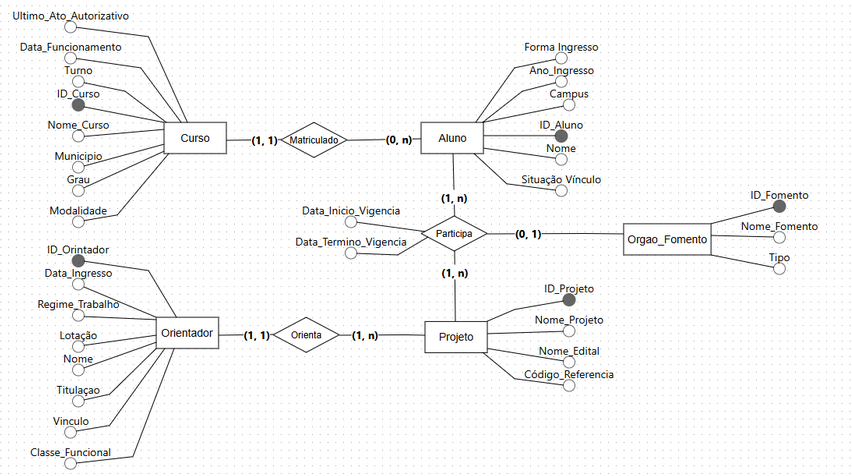

# 5. Diagrama relacional

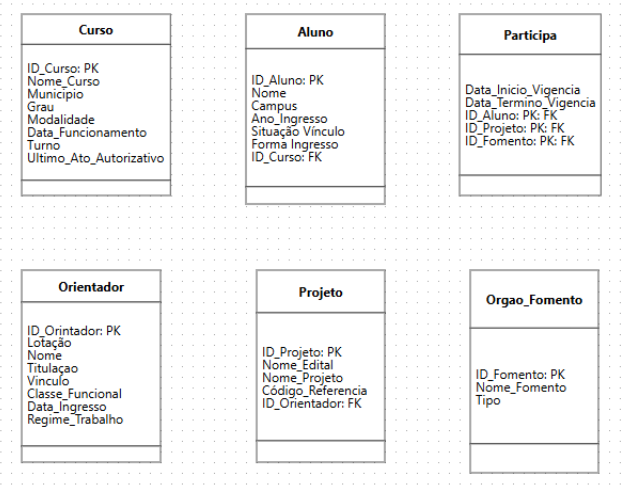

# 6. Consultas

In [1]:
import pandas as pd
import sqlite3

# Conectar ao banco de dados normalizado
conn = sqlite3.connect('ic-uftm.db')

def run(sql):
    """Executa query SQL e exibe resultado"""
    df_result = pd.read_sql_query(sql, conn)
    display(df_result)
    return df_result

print("✓ Conexão estabelecida com ic-uftm.db")
print("\nTabelas disponíveis:")
tabelas = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", conn)
display(tabelas)

✓ Conexão estabelecida com ic-uftm.db

Tabelas disponíveis:


,name
0,Curso
1,sqlite_sequence
2,Aluno
3,Orientador
4,Projeto
5,Orgao_Fomento
6,Participa


## 6.1 Duas consultas envolvendo seleção e projeção

### 6.1.1 Consulta 1
Seleciona os alunos do campus de "Iturama", exibindo apenas o nome e o campus. Usa DISTINCT para evitar repetição de nomes. Consulta na tabela normalizada **Aluno**.

In [2]:
run("""
SELECT DISTINCT
  Nome AS "Nome do Aluno", 
  Campus
FROM Aluno
WHERE Campus = 'Iturama'
""")

,Nome do Aluno,Campus
0,Ana Claudia Carneiro Leão,Iturama
1,Anthony Cruvinel Egidio,Iturama
2,Antônio Pereira Netto,Iturama
3,Gustavo Leal Alves,Iturama
4,Henrique Godoy Reis,Iturama
5,Isabel da Silva Pereira,Iturama
6,KAROLAYNE MUTIMA MEDEIROS,Iturama
7,Kauane Leonel de Sousa Medeiros,Iturama
8,Kelyssa Vitoria Rodrigues Dantas,Iturama
9,LEONARDO PORTAPILA,Iturama


,Nome do Aluno,Campus
0,Ana Claudia Carneiro Leão,Iturama
1,Anthony Cruvinel Egidio,Iturama
2,Antônio Pereira Netto,Iturama
3,Gustavo Leal Alves,Iturama
4,Henrique Godoy Reis,Iturama
5,Isabel da Silva Pereira,Iturama
6,KAROLAYNE MUTIMA MEDEIROS,Iturama
7,Kauane Leonel de Sousa Medeiros,Iturama
8,Kelyssa Vitoria Rodrigues Dantas,Iturama
9,LEONARDO PORTAPILA,Iturama


### 6.1.2 Consulta 2
Retorna os alunos que ingressaram a partir de 2020, mostrando o nome e o ano de ingresso. Consulta na tabela normalizada **Aluno**.

In [47]:
run("""
SELECT DISTINCT
  Nome AS "Nome do Aluno", 
  Ano_Ingresso AS "Ano de Ingresso"
FROM Aluno
WHERE Ano_Ingresso >= 2020
""")

,Nome do Aluno,Ano de Ingresso
0,Adelson Antonio Januario Junior,2020
1,Adônis Rossetti,2020
2,Alessandra Ferreira de Souza,2021
3,Aline Bezerra Veras,2021
4,Alycia Ferreira Costa,2021
...,...,...
286,Wailainy dos Santos Ferreira,2021
287,Yago Ferreira Silva,2022
288,Yago dos Anjos Donato dos Santos,2021
289,Yasmin Marçal Pedro,2022


,Nome do Aluno,Ano de Ingresso
0,Adelson Antonio Januario Junior,2020
1,Adônis Rossetti,2020
2,Alessandra Ferreira de Souza,2021
3,Aline Bezerra Veras,2021
4,Alycia Ferreira Costa,2021
...,...,...
286,Wailainy dos Santos Ferreira,2021
287,Yago Ferreira Silva,2022
288,Yago dos Anjos Donato dos Santos,2021
289,Yasmin Marçal Pedro,2022


## 6.2 Três consultas envolvendo junção de duas relações

### 6.2.1 Consulta 3
Relaciona alunos aos cursos e filtra cursos que sejam, simultaneamente, bacharelado e noturnos. Exibe nome, curso, grau do curso e turno, utilizando junção entre **Aluno** e **Curso**.

In [48]:
run("""
SELECT DISTINCT
  a.Nome AS "Nome do Aluno", 
  c.Nome_Curso AS "Curso do Aluno", 
  c.Grau AS "Grau do Curso", 
  c.Turno AS "Turno"
FROM Aluno a
JOIN Curso c ON a.ID_Curso = c.ID_Curso
WHERE c.Grau LIKE '%Bacharelado%' 
  AND c.Turno LIKE '%noturno%'
""")

,Nome do Aluno,Curso do Aluno,Grau do Curso,Turno
0,Ana Beatriz Batista Alfieri,SERVIÇO SOCIAL (Bacharelado),Bacharelado,noturno
1,Eduarda Gabriela Moreira,SERVIÇO SOCIAL (Bacharelado),Bacharelado,noturno
2,Raquel Aparecida da Cruz Silva,SERVIÇO SOCIAL (Bacharelado),Bacharelado,noturno
3,Sthefany Lacerda Sales,SERVIÇO SOCIAL (Bacharelado),Bacharelado,noturno


,Nome do Aluno,Curso do Aluno,Grau do Curso,Turno
0,Ana Beatriz Batista Alfieri,SERVIÇO SOCIAL (Bacharelado),Bacharelado,noturno
1,Eduarda Gabriela Moreira,SERVIÇO SOCIAL (Bacharelado),Bacharelado,noturno
2,Raquel Aparecida da Cruz Silva,SERVIÇO SOCIAL (Bacharelado),Bacharelado,noturno
3,Sthefany Lacerda Sales,SERVIÇO SOCIAL (Bacharelado),Bacharelado,noturno


### 6.2.2 Consulta 4
Exibe todos os projetos da database, ordenados pelo código de cadastro e com seu respectivo professor orientador. Faz junção de **Projeto** e **Orientador**.

In [49]:
run("""
SELECT DISTINCT
  p.Nome_Projeto AS "Título do Projeto", 
  p.Codigo_Referencia AS "Código", 
  o.Nome AS "Orientador"
FROM Projeto p
JOIN Orientador o ON p.ID_Orientador = o.ID_Orientador
ORDER BY p.Codigo_Referencia
""")

,Título do Projeto,Código,Orientador
0,ANÁLISE DO PERFIL DE INTERNAÇÕES RELACIONADAS ...,4012,ANA PAULA FERNANDES
1,Os processos de subjetivação nos livros distóp...,4024,HENRIQUE MESQUITA POMPERMAIER
2,MANUAIS DE INTRODUÇÃO À PSICOLOGIA: COMO SE DÃ...,4033,HENRIQUE MESQUITA POMPERMAIER
3,Análise da expressão de citocinas em biópsias ...,4097,JULIANA REIS MACHADO E SILVA
4,Avaliação da atividade anti-Trypanosoma cruzi ...,4117,Marcos Vinicius Da Silva
...,...,...,...
353,Construtos psicológicos positivos de universit...,8935,CAROLINA ROSA CAMPOS
354,SUBJETIVIDADES NEGRAS E ASSUJEITAMENTO: VIOLÊN...,8985,Ailton De Souza Aragao
355,ANÁLISE DO CONSUMO ALIMENTAR DE PROFESSORAS DA...,8996,RENATA DAMIAO
356,A Construção da Autoria de William Shakespeare...,9059,Verônica Calsoni Lima


,Título do Projeto,Código,Orientador
0,ANÁLISE DO PERFIL DE INTERNAÇÕES RELACIONADAS ...,4012,ANA PAULA FERNANDES
1,Os processos de subjetivação nos livros distóp...,4024,HENRIQUE MESQUITA POMPERMAIER
2,MANUAIS DE INTRODUÇÃO À PSICOLOGIA: COMO SE DÃ...,4033,HENRIQUE MESQUITA POMPERMAIER
3,Análise da expressão de citocinas em biópsias ...,4097,JULIANA REIS MACHADO E SILVA
4,Avaliação da atividade anti-Trypanosoma cruzi ...,4117,Marcos Vinicius Da Silva
...,...,...,...
353,Construtos psicológicos positivos de universit...,8935,CAROLINA ROSA CAMPOS
354,SUBJETIVIDADES NEGRAS E ASSUJEITAMENTO: VIOLÊN...,8985,Ailton De Souza Aragao
355,ANÁLISE DO CONSUMO ALIMENTAR DE PROFESSORAS DA...,8996,RENATA DAMIAO
356,A Construção da Autoria de William Shakespeare...,9059,Verônica Calsoni Lima


### 6.2.3 Consulta 5
Seleciona alunos que estão com situação "Cursando", combinando **Aluno** e **Participa**. Exibe nome e situação acadêmica.

In [11]:
run("""
SELECT DISTINCT
  a.Nome AS "Nome do Aluno", 
  a.Situacao_Vinculo AS "Situação Acadêmica"
FROM Aluno a
JOIN Participa pa ON a.ID_Aluno = pa.ID_Aluno
WHERE a.Situacao_Vinculo = 'Cursando'
""")

,Nome do Aluno,Situação Acadêmica
0,Adelson Antonio Januario Junior,Cursando
1,Adônis Rossetti,Cursando
2,Agnaldo José Braga Junior,Cursando
3,Alessandra Ferreira de Souza,Cursando
4,Aline Bezerra Veras,Cursando
...,...,...
330,Wailainy dos Santos Ferreira,Cursando
331,Yago Ferreira Silva,Cursando
332,Yago dos Anjos Donato dos Santos,Cursando
333,Yasmin Marçal Pedro,Cursando


,Nome do Aluno,Situação Acadêmica
0,Adelson Antonio Januario Junior,Cursando
1,Adônis Rossetti,Cursando
2,Agnaldo José Braga Junior,Cursando
3,Alessandra Ferreira de Souza,Cursando
4,Aline Bezerra Veras,Cursando
...,...,...
330,Wailainy dos Santos Ferreira,Cursando
331,Yago Ferreira Silva,Cursando
332,Yago dos Anjos Donato dos Santos,Cursando
333,Yasmin Marçal Pedro,Cursando


## 6.3 Três consultas envolvendo junção de três ou mais relações

### 6.3.1 Consulta 6
Retorna alunos orientados por docentes que contenham titulação de mestrado, juntando informações de **Aluno**, **Curso**, **Participa**, **Projeto** e **Orientador**. Exibe aluno, turno, nome do docente e titulação.

In [51]:
run("""
SELECT DISTINCT
  a.Nome AS "Nome do Aluno", 
  c.Turno AS "Turno do aluno", 
  o.Nome AS "Nome do Docente", 
  o.Titulacao AS "Titulação"
FROM Aluno a
JOIN Curso c ON a.ID_Curso = c.ID_Curso
JOIN Participa pa ON a.ID_Aluno = pa.ID_Aluno
JOIN Projeto p ON pa.ID_Projeto = p.ID_Projeto
JOIN Orientador o ON p.ID_Orientador = o.ID_Orientador
WHERE o.Titulacao LIKE '%MESTRADO%'
""")

,Nome do Aluno,Turno do aluno,Nome do Docente,Titulação
0,Agnaldo José Braga Junior,integral,Julio Cesar De Souza Inacio Goncalves,MESTRADO
1,Alycia Ferreira Costa,integral,MAYCON SOUSA PEGORARI,MESTRADO
2,Carlos Daniel Rezende Reston,integral,LUCIANE FERNANDA RODRIGUES MARTINHO FERNANDES,MESTRADO
3,Fernanda Costa Padovan,integral,Pedro Donizete Colombo Junior,MESTRADO
4,Gabriel Francisco Barbosa Júnior,integral,CLARITON RODRIGUES BERNADELLI,MESTRADO
5,Gabriel Marinho e Silva,integral,Pedro Donizete Colombo Junior,MESTRADO
6,João Vitor Regatieri Ameloti,integral,DEUSMAQUE CARNEIRO FERREIRA,MESTRADO
7,Júlio César de Souza Filho,integral,Julio Cesar De Souza Inacio Goncalves,MESTRADO
8,Marcos Jose de Moraes Junior,integral,PAULO BALDUINO FLABES NETO,MESTRADO
9,Mario Vítor Nunes Maia,integral,PAULO BALDUINO FLABES NETO,MESTRADO


,Nome do Aluno,Turno do aluno,Nome do Docente,Titulação
0,Agnaldo José Braga Junior,integral,Julio Cesar De Souza Inacio Goncalves,MESTRADO
1,Alycia Ferreira Costa,integral,MAYCON SOUSA PEGORARI,MESTRADO
2,Carlos Daniel Rezende Reston,integral,LUCIANE FERNANDA RODRIGUES MARTINHO FERNANDES,MESTRADO
3,Fernanda Costa Padovan,integral,Pedro Donizete Colombo Junior,MESTRADO
4,Gabriel Francisco Barbosa Júnior,integral,CLARITON RODRIGUES BERNADELLI,MESTRADO
5,Gabriel Marinho e Silva,integral,Pedro Donizete Colombo Junior,MESTRADO
6,João Vitor Regatieri Ameloti,integral,DEUSMAQUE CARNEIRO FERREIRA,MESTRADO
7,Júlio César de Souza Filho,integral,Julio Cesar De Souza Inacio Goncalves,MESTRADO
8,Marcos Jose de Moraes Junior,integral,PAULO BALDUINO FLABES NETO,MESTRADO
9,Mario Vítor Nunes Maia,integral,PAULO BALDUINO FLABES NETO,MESTRADO


### 6.3.2 Consulta 7
Lista alunos do campus Uberaba, mostrando curso, campus e título do projeto de cada aluno. Combina **Aluno**, **Curso**, **Participa** e **Projeto**.

In [27]:
run("""
SELECT DISTINCT
  a.Nome AS "Nome do Aluno", 
  c.Nome_Curso AS "Curso do Aluno", 
  a.Campus AS "Campus", 
  p.Nome_Projeto AS "Título do Projeto"
FROM Aluno a
JOIN Curso c ON a.ID_Curso = c.ID_Curso
JOIN Participa pa ON a.ID_Aluno = pa.ID_Aluno
JOIN Projeto p ON pa.ID_Projeto = p.ID_Projeto
WHERE a.Campus = 'Uberaba'
""")

,Nome do Aluno,Curso do Aluno,Campus,Título do Projeto
0,Adelson Antonio Januario Junior,EDUCAÇÃO FÍSICA (Bacharelado),Uberaba,EFEITO DO TREINAMENTO RESISTIDO NA COMPOSIÇÃO ...
1,Adônis Rossetti,MEDICINA (Bacharelado),Uberaba,O impacto das mídias sociais na visão corporal...
2,Agnaldo José Braga Junior,ENGENHARIA AMBIENTAL (Bacharelado),Uberaba,Efeitos da sujidade no desempenho de placas fo...
3,Alessandra Ferreira de Souza,NUTRIÇÃO (Bacharelado),Uberaba,Produção e Caracterização de Bebida Láctea Fer...
4,Aline Bezerra Veras,MEDICINA (Bacharelado),Uberaba,Atividade antibacteriana e anti-biofilme de Co...
...,...,...,...,...
328,Wailainy dos Santos Ferreira,FISIOTERAPIA (Bacharelado),Uberaba,Prevalência de saúde cardiovascular ideal em p...
329,Yago Ferreira Silva,MATEMÁTICA (Licenciatura),Uberaba,Arquivo Pessoal Ubiratan D'Ambrosio: um resgat...
330,Yago dos Anjos Donato dos Santos,EDUCAÇÃO FÍSICA (Bacharelado),Uberaba,EFEITO DA INTENSIDADE DO TREINAMENTO DE FORÇA ...
331,Yasmin Marçal Pedro,FISIOTERAPIA (Bacharelado),Uberaba,O manejo da dor em recém-nascidos internados n...


,Nome do Aluno,Curso do Aluno,Campus,Título do Projeto
0,Adelson Antonio Januario Junior,EDUCAÇÃO FÍSICA (Bacharelado),Uberaba,EFEITO DO TREINAMENTO RESISTIDO NA COMPOSIÇÃO ...
1,Adônis Rossetti,MEDICINA (Bacharelado),Uberaba,O impacto das mídias sociais na visão corporal...
2,Agnaldo José Braga Junior,ENGENHARIA AMBIENTAL (Bacharelado),Uberaba,Efeitos da sujidade no desempenho de placas fo...
3,Alessandra Ferreira de Souza,NUTRIÇÃO (Bacharelado),Uberaba,Produção e Caracterização de Bebida Láctea Fer...
4,Aline Bezerra Veras,MEDICINA (Bacharelado),Uberaba,Atividade antibacteriana e anti-biofilme de Co...
...,...,...,...,...
328,Wailainy dos Santos Ferreira,FISIOTERAPIA (Bacharelado),Uberaba,Prevalência de saúde cardiovascular ideal em p...
329,Yago Ferreira Silva,MATEMÁTICA (Licenciatura),Uberaba,Arquivo Pessoal Ubiratan D'Ambrosio: um resgat...
330,Yago dos Anjos Donato dos Santos,EDUCAÇÃO FÍSICA (Bacharelado),Uberaba,EFEITO DA INTENSIDADE DO TREINAMENTO DE FORÇA ...
331,Yasmin Marçal Pedro,FISIOTERAPIA (Bacharelado),Uberaba,O manejo da dor em recém-nascidos internados n...


### 6.3.3 Consulta 8
Lista os alunos que, simultaneamente, ingressaram via SISU e possuem fomento CNPq. Relaciona **Aluno**, **Participa** e **Orgao_Fomento**.

In [28]:
run("""
SELECT DISTINCT
  a.Nome AS "Nome do Aluno",
  a.Forma_Ingresso AS "Forma de Ingresso",
  of.Nome_Fomento AS "Fomento"
FROM Aluno a
JOIN Participa pa ON a.ID_Aluno = pa.ID_Aluno
JOIN Orgao_Fomento of ON pa.ID_Fomento = of.ID_Fomento
WHERE a.Forma_Ingresso LIKE '%SISU%'
  AND of.Nome_Fomento LIKE '%CNPq%'
""")

,Nome do Aluno,Forma de Ingresso,Fomento
0,Agnaldo José Braga Junior,Ingresso via SISU\t,PIBIC-Af/CNPq
1,Ana Carolina Monaro Barboza,Ingresso via SISU\t,PIBIC/CNPq
2,Ana Clara Silva de Morais,Ingresso via SISU\t,PIBIC/CNPq
3,Anthony Cruvinel Egidio,Ingresso via SISU\t,PIBIC-Af/CNPq
4,Arthur da Costa Escarela,Ingresso via SISU\t,PIBIC/CNPq
5,Audrey Susan Clug,Ingresso via SISU\t,PIBIC/CNPq
6,Augusto Giachini Barbosa,Ingresso via SISU\t,PIBIC-Af/CNPq
7,Beatriz Barbosa Antolini,Ingresso via SISU\t,PIBIC/CNPq
8,Brenda Telis Pereira,Ingresso via SISU\t,PIBIC/CNPq
9,Bruna Cavichioli Vieira Sardinha,Ingresso via SISU\t,PIBIC/CNPq


,Nome do Aluno,Forma de Ingresso,Fomento
0,Agnaldo José Braga Junior,Ingresso via SISU\t,PIBIC-Af/CNPq
1,Ana Carolina Monaro Barboza,Ingresso via SISU\t,PIBIC/CNPq
2,Ana Clara Silva de Morais,Ingresso via SISU\t,PIBIC/CNPq
3,Anthony Cruvinel Egidio,Ingresso via SISU\t,PIBIC-Af/CNPq
4,Arthur da Costa Escarela,Ingresso via SISU\t,PIBIC/CNPq
5,Audrey Susan Clug,Ingresso via SISU\t,PIBIC/CNPq
6,Augusto Giachini Barbosa,Ingresso via SISU\t,PIBIC-Af/CNPq
7,Beatriz Barbosa Antolini,Ingresso via SISU\t,PIBIC/CNPq
8,Brenda Telis Pereira,Ingresso via SISU\t,PIBIC/CNPq
9,Bruna Cavichioli Vieira Sardinha,Ingresso via SISU\t,PIBIC/CNPq


## 6.4 Duas consultas envolvendo agregação sobre junção de duas ou mais relações

### 6.4.1 Consulta 9
Agrupa os alunos por município do curso e contabiliza quantos alunos distintos pertencem a cada localidade. Combina **Aluno** e **Curso**.

In [54]:
run("""
SELECT
  c.Municipio AS "Município", 
  COUNT(DISTINCT a.ID_Aluno) AS "Número de alunos"
FROM Aluno a
JOIN Curso c ON a.ID_Curso = c.ID_Curso
GROUP BY c.Municipio
ORDER BY COUNT(DISTINCT a.ID_Aluno) ASC
""")

,Município,Número de alunos
0,Iturama,33
1,Uberaba,304


,Município,Número de alunos
0,Iturama,33
1,Uberaba,304


### 6.4.2 Consulta 10
Conta quantos orientadores distintos aparecem em cada titulação. Utiliza agregação sobre a tabela **Orientador** para identificar quantos professores atuam em cada nível de formação.

In [55]:
run("""
SELECT
  o.Titulacao AS "Titulação", 
  COUNT(DISTINCT o.ID_Orientador) AS "Número de Docentes"
FROM Orientador o
JOIN Projeto p ON o.ID_Orientador = p.ID_Orientador
GROUP BY o.Titulacao
ORDER BY COUNT(DISTINCT o.ID_Orientador) ASC
""")

,Titulação,Número de Docentes
0,MESTRADO,9
1,ENSINO SUPERIOR,76
2,DOUTORADO,121


,Titulação,Número de Docentes
0,MESTRADO,9
1,ENSINO SUPERIOR,76
2,DOUTORADO,121


# 7. Autoavaliação dos membros

- **Arthur Augusto Paiva Lemos (2023427414)**: Responsável pelo desenvolvimento do **diagrama ER (Entidade-Relacionamento)** e do **diagrama relacional**.

- **Rafaela Kesia Ferreira da Silva (2025019879)**: Encarregada da elaboração das **10 consultas SQL** exigidas pelo trabalho.

- **Filipe Henrique Nunes (2023038329)**: Desenvolveu a **aplicação web interativa** utilizando Streamlit, proporcionando uma interface para visualização e exploração dos dados processados.
- **Raissa Gonçalves Diniz (2022055823)**: Responsável pelo processo de **enriquecimento e pré-processamento dos dados**. 